<a href="https://colab.research.google.com/github/icy-mountain/resp_sounds/blob/main/keras_part_of_cnn_detection_of_wheezes_and_crackles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import joblib
import wave
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
from IPython.display import Audio
import scipy
from sklearn.model_selection import StratifiedKFold as SKFold
import librosa
import librosa.display
import tensorflow as tf
import tensorflow.keras as keras
import io
from google.colab.patches import cv2_imshow
import math
import copy
%matplotlib inline
path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_4class.dmp')

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class.dmp')

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_filter.dmp')

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_rmmargin.dmp')

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]
sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]

In [ ]:
print(f"train none:{len(training_clips['none'])} train noise:{len(training_clips['noise'])}")
print(f"train none:{len(test_clips['none'])} train noise:{len(test_clips['noise'])}")

train none:6070 train noise:5334
train none:768 train noise:664


In [ ]:
training_clips['none'][0][0].shape

(50, 245, 1)

In [ ]:
training_clips["none"][1][2]

222

Text(0.5, 1.0, 'Noise')

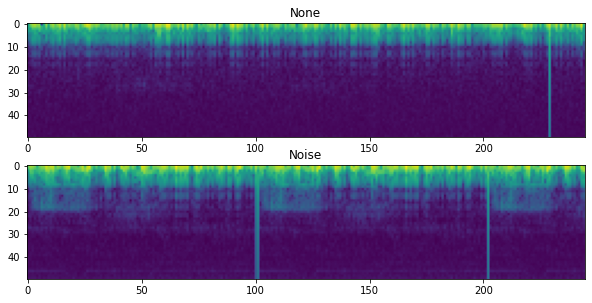

In [ ]:
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['noise'][ind][0].reshape(sample_height, sample_width))
plt.title('Noise')

In [42]:
# !git config --global user.email "ym.1211@icloud.com"
# !git config --global user.name "icy-mountain"


icy-mountain


In [52]:
# !git commit -m "init"
# !git remote add origin https://github.com/icy-mountain/resp_sounds.git
# !git branch -M main
# !git push -u origin main
# !git remote rm origin

fatal: could not read Username for 'https://github.com': No such device or address


### 各種データフレームの読み込み

In [ ]:
# patient_data.csv:患者の背景データ
# recording_info.csv:ファイル名を解析したデータ
# recording_anno.csv: ファイル内を解析したデータ
# file_crwh_counts.csv:そのファイルでどれだけcrackling,whistlingが起こったか
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})
recording_info = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_info.csv", index_col=0)
recording_anno = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_anno.csv", index_col=0)
recording_anno = recording_anno.astype({'Start':'float16', 'End':'float16', 'Crackles':'uint8', 'Wheezes':'uint8', 'cr':'uint8', 'wh':'uint8', 'cw':'uint8', 'no':'uint8', 'noise':'uint8'})
file_crwh_counts = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/file_crwh_counts.csv", index_col=0)

In [ ]:
# それぞれの音声のみ含むファイル抽出
cr_files = recording_anno[(recording_anno["Crackles"] == 1) & (recording_anno["Wheezes"] == 0)]
wh_files = recording_anno[(recording_anno["Crackles"] == 0) & (recording_anno["Wheezes"] == 1)]
no_files = recording_anno[(recording_anno["Crackles"] == 0) & (recording_anno["Wheezes"] == 0)]
cw_files = recording_anno[(recording_anno["Crackles"] == 1) & (recording_anno["Wheezes"] == 1)]
print(f"{len(cr_files)} {len(wh_files)} {len(no_files)} {len(cw_files)}")

1864 886 3642 506


In [ ]:
# new_file.to_csv('/content/drive/My Drive/grad_article/recording_anno.csv')

In [ ]:
# recording_anno[recording_anno["Filename"] == "158_2p2_Ar_mc_AKGC417L"]
# new_file = recording_anno.reset_index(drop=True)
# new_file
for i in recording_anno[recording_anno["Filename"] == "226_1b1_Pl_sc_LittC2SE"].index:
  print(type(i))
  break
print(type(recording_anno[recording_anno["Filename"] == "226_1b1_Pl_sc_LittC2SE"].index[0]))

<class 'int'>
<class 'numpy.int64'>


In [ ]:
recording_anno[:10]

Filename      Start        End  Crackles  ...  wh  cw  no  noise
0  101_1b1_Al_sc_Meditron   0.036011   0.579102         0  ...   0   0   1      0
1  101_1b1_Al_sc_Meditron   0.579102   2.449219         0  ...   0   0   1      0
2  101_1b1_Al_sc_Meditron   2.449219   3.892578         0  ...   0   0   1      0
3  101_1b1_Al_sc_Meditron   3.892578   5.792969         0  ...   0   0   1      0
4  101_1b1_Al_sc_Meditron   5.792969   7.519531         0  ...   0   0   1      0
5  101_1b1_Al_sc_Meditron   7.519531   9.281250         0  ...   0   0   1      0
6  101_1b1_Al_sc_Meditron   9.281250  11.148438         0  ...   0   0   1      0
7  101_1b1_Al_sc_Meditron  11.148438  13.039062         0  ...   0   0   1      0
8  101_1b1_Al_sc_Meditron  13.039062  14.718750         0  ...   0   0   1      0
9  101_1b1_Al_sc_Meditron  14.718750  16.703125         0  ...   0   0   1      0

[10 rows x 10 columns]

### to spec image

(144, 216, 3)


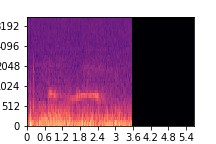

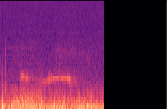

In [ ]:
fig = plt.Figure(figsize=(3, 2))
# fig = plt.Figure() #元々は6,4
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
hoge = librosa.display.specshow(training_clips['none'][0][0].reshape(sample_height, sample_width), ax=ax, y_axis='mel', x_axis='s')
buf = io.BytesIO()
fig.savefig(buf, format='png') 
enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
hoge = cv2.imdecode(enc, 1)
print(hoge.shape)
cv2_imshow(hoge)
cv2_imshow(hoge[17:-18, 28:-21, :])
# hoge[35:-35, 54:-43, :]

In [ ]:
test_clips['none'][0]

In [ ]:
def to_spec_img(clips):
  '''
    input: each class clip
    output: new class clip
  '''
  for i in range(len(clips)):
    mel_spect = clips[i][0].reshape(sample_height, sample_width)
    fig = plt.Figure(figsize=(3,2)) #指定しないと(6,4) [35:-35, 54:-43, :]
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    hoge = librosa.display.specshow(mel_spect[0:,0:], ax = ax, y_axis='mel', x_axis='s', x_coords=np.arange(0, 5, 5./len(mel_spect[0])))
    buf = io.BytesIO()
    fig.savefig(buf, format='png') 
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
    hoge = cv2.imdecode(enc, 1) #decode
    X = (hoge[17:-18, 28:-21, :] / 255.0).astype(np.float32)
    # print(f'{X.max()} {X.min()} {X.dtype} {X.shape}')
    new_tuple = (X, clips[i][1]) 
    clips[i] = new_tuple

In [ ]:
%%time
test_noise_clips = copy.deepcopy(test_clips['noise'])
to_spec_img(test_noise_clips)

CPU times: user 51.4 s, sys: 558 ms, total: 51.9 s
Wall time: 52 s


In [ ]:
test_noise_clips[33][1]

1

In [ ]:
joblib.dump(test_noise_clips,'/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2.dmp', compress=3)

['/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2.dmp']

In [ ]:
load_sample = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_none_img_dict2.dmp')

In [ ]:
load_sample[0]

(array([[[0.03921569, 0.00784314, 0.01176471],
         [0.04705882, 0.01176471, 0.01960784],
         [0.03921569, 0.00784314, 0.01176471],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.07450981, 0.07450981, 0.07450981]],
 
        [[0.20392157, 0.05098039, 0.07450981],
         [0.24705882, 0.0627451 , 0.09803922],
         [0.20392157, 0.05098039, 0.07450981],
         ...,
         [0.01568628, 0.        , 0.        ],
         [0.01568628, 0.        , 0.        ],
         [0.2       , 0.2       , 0.2       ]],
 
        [[0.1764706 , 0.04313726, 0.0627451 ],
         [0.28627452, 0.06666667, 0.11764706],
         [0.23921569, 0.05882353, 0.09411765],
         ...,
         [0.01568628, 0.        , 0.        ],
         [0.01568628, 0.        , 0.        ],
         [0.2       , 0.2       , 0.2       ]],
 
        ...,
 
        [[0.47058824, 0.6901961 , 0.99607843],
         [0.6392157 , 0.8862745 , 0.99215

## **2class with patient**

### data preprocess 

In [ ]:
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})

In [ ]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid]

# patient_data[patient_data['Sex'].isnull()]
# patient_data[patient_data['Age'].isnull()]
# patient_data[patient_data['Patient number'] == 122]
'''
P_ID
Age,Sex is null = 223
BMI, Weight Height is numm = 108,183,190,197,217,222,223 

Sex 
F:46
M:79
nan:1

223 sex->F, Age->43.0
'''
# patient_data[(patient_data['Adult BMI (kg/m2)'].isnull()) & (patient_data['Child Weight (kg)'].isnull()) & (patient_data['Child Height (cm)'].isnull())]

'\nP_ID\nAge,Sex is null = 223\nBMI, Weight Height is numm = 108,183,190,197,217,222,223 \n\nSex \nF:46\nM:79\nnan:1\n\n223 sex->F, Age->43.0\n'

In [ ]:
# patient_data[patient_data['Patient number'] == 223]['Sex'] = 43.0
patient_data.loc[122, 'Age'] = 43.0

In [ ]:
patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == "M" else 0)

In [ ]:
patient_data['Age'] /= patient_data['Age'].max()

In [ ]:
patient_data = patient_data.astype({'Sex':'int8'})

In [ ]:
patient_data.describe()

Patient number         Age  ...  Child Weight (kg)  Child Height (cm)
count      126.000000  126.000000  ...          44.000000          42.000000
mean       163.500000    0.462287  ...          21.361136         104.652381
std         36.517119    0.344946  ...          17.150885          30.793128
min        101.000000    0.002688  ...           7.140000          64.000000
25%        132.250000    0.045699  ...          11.755000          81.250000
50%        163.500000    0.645161  ...          15.100000          99.500000
75%        194.750000    0.760753  ...          24.325000         117.750000
max        226.000000    1.000000  ...          80.000000         183.000000

[8 rows x 6 columns]

In [ ]:
pid = training_clips['noise'][0][2]
patient_data[patient_data['Patient number'] == pid][['Sex', 'Age']].values

array([[1.        , 0.80645161]])

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides, p_info):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        self.p_info = p_info
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 2#
    
    def generate_keras(self, batch_size):
        cursor = [0, 0] #
        while True:
            i = 0
            X1, X2, y = [],[],[]
            for _ in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X1.append(s[0])
                y.append(s[1])
                p_id = clip[2]
                info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                X2.append(info)
                i = (i + 1) % 2 # go to next class
            yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 1)) ,np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size,1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, p_info, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
        self.p_info = p_info
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X1,X2,y = [],[],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X1.append(s[0])
                    y.append(s[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                else:
                    X1.append(clip[0])
                    y.append(clip[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                    
            yield ([np.reshape(X1, (batch_size,sample_height, sample_width,1)), np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size, 1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]
[none_train, noise_train] = [training_clips['none'], training_clips['noise']]
[none_test, noise_test] =  [test_clips['none'], test_clips['noise']]

np.random.shuffle(none_train)
np.random.shuffle(noise_train)

#Data pipeline objects
train_gen = data_generator([none_train, noise_train], [1,1], patient_data)
test_gen = feed_all([none_test, noise_test], patient_data)

In [ ]:
# train_gen.generate_keras(32).__next__()

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 1), name="spec")
pinfo_input = keras.Input(shape=(2,), name="pinfo")

pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)
'''
spect
'''

spect_features = layers.Conv2D(128, [7,11], strides = [2,2], padding = 'SAME')(spect_input)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

spect_features = layers.Conv2D(256, [5,5], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(256, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(256, [3,3], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

# 2*8*512
spect_features = tf.reshape(spect_features, [-1, 16, 512])
# spect_features = layers.LSTM(256, return_sequences=True)(spect_features)
spect_features = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(spect_features)

spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dense(4096, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(512, activation='relu')(spect_features)


x = layers.concatenate([spect_features, pinfo_features])
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'binary_crossentropy', metrics = ['acc'])


In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [ ]:
batch_size = 64
n_epochs = 30
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/30
166/166 [==============================] - 41s 221ms/step - loss: 0.6859 - acc: 0.5465 - val_loss: 0.6633 - val_acc: 0.6257
Epoch 2/30
166/166 [==============================] - 36s 215ms/step - loss: 0.6557 - acc: 0.6167 - val_loss: 0.6305 - val_acc: 0.6527
Epoch 3/30
166/166 [==============================] - 35s 213ms/step - loss: 0.6200 - acc: 0.6636 - val_loss: 0.6090 - val_acc: 0.6761
Epoch 4/30
166/166 [==============================] - 35s 212ms/step - loss: 0.6045 - acc: 0.6825 - val_loss: 0.5966 - val_acc: 0.6832
Epoch 5/30
166/166 [==============================] - 35s 212ms/step - loss: 0.5814 - acc: 0.6943 - val_loss: 0.5949 - val_acc: 0.6832
Epoch 6/30
166/166 [==============================] - 35s 212ms/step - loss: 0.5600 - acc: 0.7108 - val_loss: 0.5867 - val_acc: 0.6818
Epoch 7/30
166/166 [==============================] - 35s 211ms/step - loss: 0.5371 - acc: 0.7289 - val_loss: 0.6120 - val_acc: 0.6875
Epoch 8/30
166/166 [==============================] - 3

Text(0.5, 1.0, 'Loss')

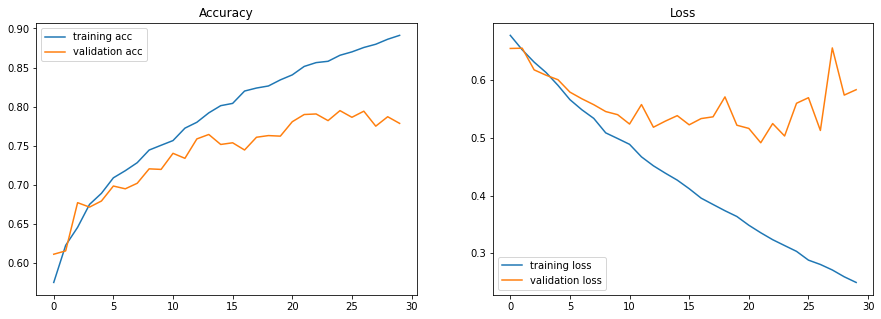

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
fname = "0103_2303_model"
model.save('/content/drive/MyDrive/grad_article/models/' + fname)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/grad_article/models/0103_2303_model/assets


In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
pred = model.predict(test_set[0])
predictions =  np.where(pred > 0.5, 1, 0)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
len(predictions[test_set[1] == predictions]) / len(predictions)

0.8007017543859649

In [ ]:
# 間違えたインデックス
idx = np.array([i for i in range(len(predictions))])
hoge = test_set[1] != predictions
hoge = np.reshape(hoge, len(predictions))
f_idx = idx[hoge]

In [ ]:
562 + 196 + 88 + 579

1425

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_test = np.reshape(test_set[1], len(test_set[1]))
y_pred = np.reshape(predictions, len(test_set[1]))
cm = confusion_matrix(y_test, y_pred)
'''
TN FP
FN TP
'''
print(cm)

print(f1_score(y_test, y_pred))

print(precision_score(y_test, y_pred))

print(recall_score(y_test, y_pred))

[[562 196]
 [ 88 579]]
0.8030513176144243
0.7470967741935484
0.8680659670164917


In [ ]:
# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img

# Grad−CAM計算用
from tensorflow.keras import models
IMAGE_SIZE=(sample_width, sample_height)# xy が逆

In [ ]:
def grad_cam(input_model, x, info, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    # preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model((X,info))
        class_idx = np.argmax(predictions[0])
        print(f"predict {class_idx}")
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    all_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(all_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

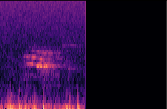

(109, 167, 3)
154


In [ ]:
x = none_test[0][0]
cv2_imshow(x * 255.0)
print(x.shape)
print(none_test[0][2])
# IMAGE_SIZE

In [ ]:
fname = "0103_2303_model"
model = keras.models.load_model('/content/drive/MyDrive/grad_article/models/' + fname)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec (InputLayer)               [(None, 50, 245, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 123, 128) 9984        spec[0][0]                       
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 25, 123, 128) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 62, 128)  0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

predict 0


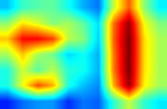

In [ ]:
target_layer = 'conv2d_5'
p_id = none_test[0][2]
info = patient_data[patient_data['Patient number'] == p_id][['Sex', 'Age']].values
cam = grad_cam(model, x, info, target_layer)
array_to_img(cam)

## **Image for 2class**

### data check

In [ ]:
train_none = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_none_img_dict2_rmmargin.dmp')
train_noise = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_noise_img_dict2_rmmargin.dmp')

test_none = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_none_img_dict2_rmmargin.dmp')
test_noise = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2_rmmargin.dmp')

In [ ]:
training_clips = {'none':train_none, 'noise':train_noise}
test_clips = {'none':test_none, 'noise':test_noise}

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\nnoise:{len(src_dict['noise'])}")

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6104
noise:5324

[Test set]
none:751
noise:669


In [ ]:
training_clips['none']

[(array([[[0.00784314, 0.        , 0.        ],
          [0.01176471, 0.        , 0.        ],
          [0.00784314, 0.        , 0.        ],
          ...,
          [0.01176471, 0.        , 0.        ],
          [0.01176471, 0.        , 0.        ],
          [0.07450981, 0.07450981, 0.07450981]],
  
         [[0.04313726, 0.00784314, 0.00784314],
          [0.05882353, 0.01176471, 0.01176471],
          [0.04313726, 0.00784314, 0.00784314],
          ...,
          [0.07058824, 0.01176471, 0.01176471],
          [0.05882353, 0.01176471, 0.01176471],
          [0.2       , 0.2       , 0.2       ]],
  
         [[0.03529412, 0.00392157, 0.00784314],
          [0.04313726, 0.00784314, 0.00784314],
          [0.03529412, 0.00392157, 0.00784314],
          ...,
          [0.05882353, 0.01176471, 0.01176471],
          [0.07058824, 0.01176471, 0.01176471],
          [0.2       , 0.2       , 0.2       ]],
  
         ...,
  
         [[0.42745098, 0.62352943, 0.99607843],
          [0.5

109
167


Text(0.5, 1.0, 'Noise')

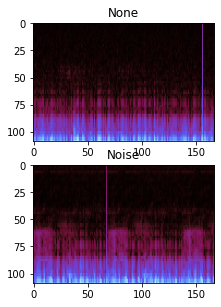

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
print(sample_height)
print(sample_width)
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0])
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['noise'][ind][0])
plt.title('Noise')


### data preprocess 

In [ ]:
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})

In [ ]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid]

# patient_data[patient_data['Sex'].isnull()]
# patient_data[patient_data['Age'].isnull()]
# patient_data[patient_data['Patient number'] == 122]
'''
P_ID
Age,Sex is null = 223
BMI, Weight Height is numm = 108,183,190,197,217,222,223 

Sex 
F:46
M:79
nan:1

223 sex->F, Age->43.0
'''
# patient_data[(patient_data['Adult BMI (kg/m2)'].isnull()) & (patient_data['Child Weight (kg)'].isnull()) & (patient_data['Child Height (cm)'].isnull())]

'\nP_ID\nAge,Sex is null = 223\nBMI, Weight Height is numm = 108,183,190,197,217,222,223 \n\nSex \nF:46\nM:79\nnan:1\n\n223 sex->F, Age->43.0\n'

In [ ]:
# patient_data[patient_data['Patient number'] == 223]['Sex'] = 43.0
patient_data.loc[122, 'Age'] = 43.0

In [ ]:
patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == "M" else 0)

In [ ]:
patient_data['Age'] /= patient_data['Age'].max()

In [ ]:
patient_data = patient_data.astype({'Sex':'int8'})

In [ ]:
patient_data.describe()

Patient number         Age  ...  Child Weight (kg)  Child Height (cm)
count      126.000000  126.000000  ...          44.000000          42.000000
mean       163.500000    0.462287  ...          21.361136         104.652381
std         36.517119    0.344946  ...          17.150885          30.793128
min        101.000000    0.002688  ...           7.140000          64.000000
25%        132.250000    0.045699  ...          11.755000          81.250000
50%        163.500000    0.645161  ...          15.100000          99.500000
75%        194.750000    0.760753  ...          24.325000         117.750000
max        226.000000    1.000000  ...          80.000000         183.000000

[8 rows x 6 columns]

In [ ]:
pid = training_clips['noise'][0][2]
patient_data[patient_data['Patient number'] == pid][['Sex', 'Age']].values

array([[1.        , 0.86021505]])

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides, p_info):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        self.p_info = p_info
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 2#
    
    def generate_keras(self, batch_size):
        cursor = [0, 0] #
        while True:
            i = 0
            X1, X2, y = [],[],[]
            for _ in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X1.append(s[0])
                y.append(s[1])
                p_id = clip[2]
                info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                X2.append(info)
                i = (i + 1) % 2 # go to next class
            yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 3)) ,np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size,1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, p_info, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
        self.p_info = p_info
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X1,X2,y = [],[],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X1.append(s[0])
                    y.append(s[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                else:
                    X1.append(clip[0])
                    y.append(clip[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                    
            yield ([np.reshape(X1, (batch_size,sample_height, sample_width,3)), np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size, 1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
[none_train, noise_train] = [joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_none_img_dict2_filter.dmp'), joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_noise_img_dict2_filter.dmp')]
[none_test, noise_test] =  [joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_none_img_dict2_filter.dmp'),joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2_filter.dmp')]

np.random.shuffle(none_train)
np.random.shuffle(noise_train)

sample_height = none_train[0][0].shape[0]
sample_width = none_train[0][0].shape[1]

#Data pipeline objects
train_gen = data_generator([none_train, noise_train], [1,1], patient_data)
test_gen = feed_all([none_test, noise_test], patient_data)

In [ ]:
del none_train
del noise_train
del none_test
del noise_test

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 3), name="spec")
pinfo_input = keras.Input(shape=(2,), name="pinfo")

pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)
'''
spect
'''
spect_features = layers.Conv2D(128, [7,11], strides = [2,2], padding = 'SAME')(spect_input)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

spect_features = layers.Conv2D(256, [5,5], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(256, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(256, [3,3], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
# spect_features = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(spect_features)

spect_features = layers.Conv2D(1024, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(1024, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)


spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dense(4096, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(512, activation='relu')(spect_features)


x = layers.concatenate([spect_features, pinfo_features])
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'binary_crossentropy', metrics = ['acc'])


In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, show_shapes=True, show_layer_names = True)
# from IPython.display import Image
# Image(filename='model.png')

In [ ]:
batch_size = 64
n_epochs = 30
stats = model.fit(train_gen.generate_keras(batch_size),
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/30
166/166 [==============================] - 28s 159ms/step - loss: 0.6928 - acc: 0.5134 - val_loss: 0.6914 - val_acc: 0.5163
Epoch 2/30
166/166 [==============================] - 26s 156ms/step - loss: 0.6902 - acc: 0.5356 - val_loss: 0.6692 - val_acc: 0.6080
Epoch 3/30
166/166 [==============================] - 26s 156ms/step - loss: 0.6768 - acc: 0.5896 - val_loss: 0.6583 - val_acc: 0.6172
Epoch 4/30
166/166 [==============================] - 26s 157ms/step - loss: 0.6660 - acc: 0.6058 - val_loss: 0.6383 - val_acc: 0.6328
Epoch 5/30
166/166 [==============================] - 26s 157ms/step - loss: 0.6432 - acc: 0.6294 - val_loss: 0.6194 - val_acc: 0.6555
Epoch 6/30
166/166 [==============================] - 26s 156ms/step - loss: 0.6189 - acc: 0.6630 - val_loss: 0.6133 - val_acc: 0.6577
Epoch 7/30
166/166 [==============================] - 26s 157ms/step - loss: 0.6156 - acc: 0.6609 - val_loss: 0.5988 - val_acc: 0.6605
Epoch 8/30
166/166 [==============================] - 2

Text(0.5, 1.0, 'Loss')

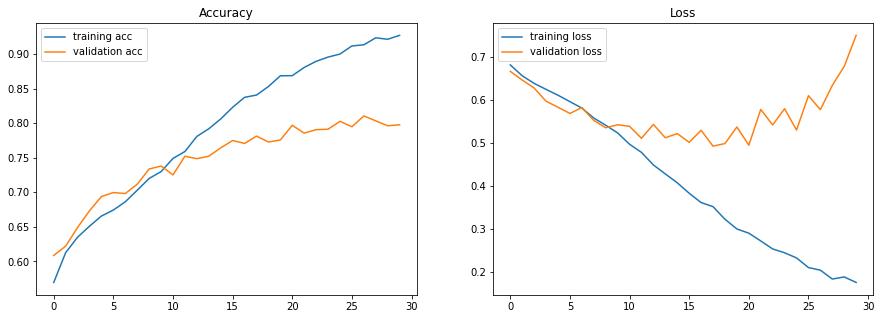

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
pred = model.predict(test_set[0])
predictions =  np.where(pred > 0.5, 1, 0)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
len(predictions[test_set[1] == predictions]) / len(predictions)

0.8036723163841808

###model save load

In [ ]:
fname = "0113_0003_img_model"
model.save('/content/drive/MyDrive/grad_article/models/' + fname)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/grad_article/models/0113_0003_img_model/assets


In [ ]:
fname = "0113_0003_img_model"
new_model = keras.models.load_model('/content/drive/MyDrive/grad_article/models/' + fname)

In [ ]:
new_model.summary()

In [ ]:
model = new_model

### gradcam

In [ ]:
# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img

# Grad−CAM計算用
from tensorflow.keras import models
IMAGE_SIZE=(sample_width, sample_height)# xy が逆
print(IMAGE_SIZE)

(167, 109)


In [ ]:
def grad_cam(input_model, x, info, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    # preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model((X,info))
        print(predictions)
        class_idx = 1 if predictions[0] > 0.5 else 0 
        print(f"predict {class_idx}")
        loss = predictions[:, 0]

    # 勾配を計算
    output = conv_outputs[0]
    # d_L/d_output
    grads = tape.gradient(loss, conv_outputs)[0]

    all_grads = grads
    # 勾配を平均化して、レイヤーの出力に乗じる
    weights = np.mean(all_grads, axis=(0, 1))
    cam = np.matmul(output, weights)
      
    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    # output_image = np.uint8(rgb_cam/2 + x/2)
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_test = np.reshape(test_set[1], len(test_set[1]))
y_pred = np.reshape(predictions, len(test_set[1]))
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[607 145]
 [165 499]]


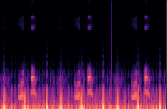

(109, 167, 3)
109


(167, 109)

In [ ]:
x = test_clips['none'][0][0]
cv2_imshow(x * 255.0)
print(x.shape)
print(test_clips['none'][0][2])
IMAGE_SIZE

In [ ]:
model.summary()

In [ ]:
def cmpr_spec(idx):
  target_layer = 'conv2d_7'
  tgt = 'noise'

  x = test_clips[tgt][idx][0]
  which = test_clips[tgt][idx][1]
  p_id = test_clips[tgt][idx][2]
  info = patient_data[patient_data['Patient number'] == p_id][['Sex', 'Age']].values
  print(which)
  cv2_imshow(x*255)
  cam = grad_cam(model, x, info, target_layer)

  im_h = cv2.vconcat([cv2.cvtColor(x*255.0 , cv2.COLOR_BGR2RGB), cam])
  # array_to_img(cv2.cvtColor(np.uint8(x*255) , cv2.COLOR_BGR2RGB))
  return im_h

1


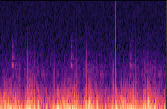

tf.Tensor([[0.9635593]], shape=(1, 1), dtype=float32)
predict 1
weights_shape(512,) output_shape:(7, 11, 512)


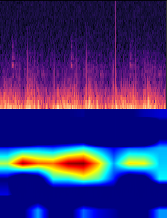

In [ ]:
array_to_img(cmpr_spec(1))

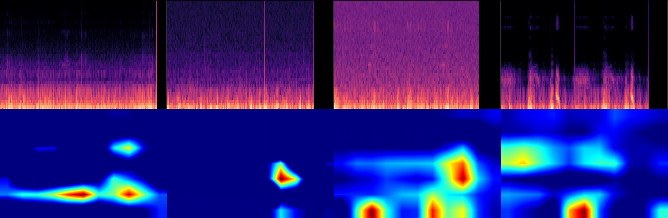

In [ ]:
im_2 = im_h
array_to_img(im_2)

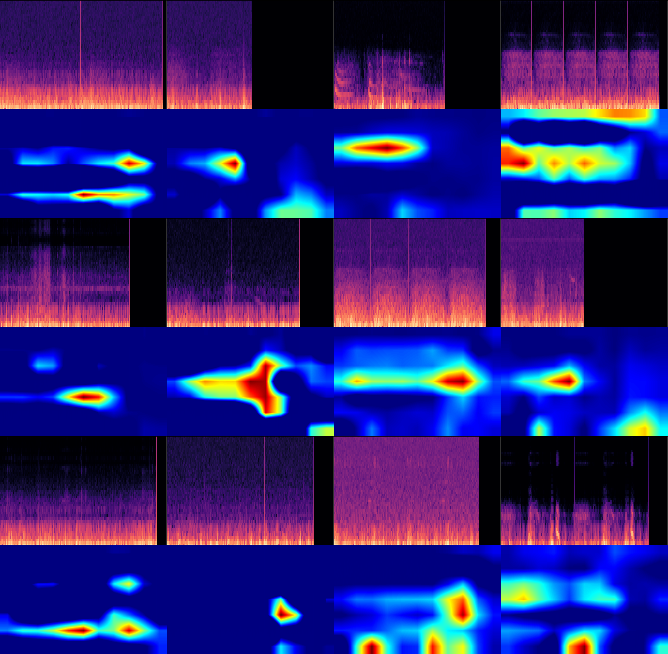

In [ ]:
im_full = cv2.vconcat([im_h, im_2])
array_to_img(im_full)

1


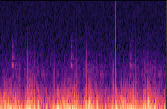

predict 0
1


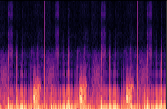

predict 1


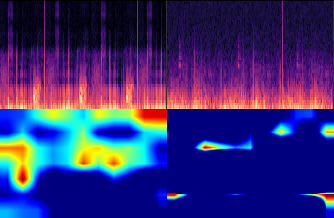

In [ ]:
im_h = cmpr_spec(1)
im_h = cv2.hconcat([cmpr_spec(2), im_h])
array_to_img(im_h)

### resp sound

In [ ]:
recoring_anno = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_anno.csv", index_col=0)

NameError: ignored

In [ ]:
pid = test_clips['noise'][0][2]
patient_data[patient_data['Patient number'] == pid]
# recoring_anno[recoring_anno['Filename']]
recoring_anno[recoring_anno['Filename'].str.contains(str(pid))].index

Int64Index([4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876,
            ...
            4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992],
           dtype='int64', length=126)

## **2class**

### data check

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\nnoise:{len(src_dict['noise'])}")

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6078
noise:5328

[Test set]
none:764
noise:667


In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['noise'][ind][0].reshape(sample_height, sample_width))
plt.title('Noise')


### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 2#
    
    def generate_keras(self, batch_size):
        cursor = [0, 0] #
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 2 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,1)))#

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]
[none_train, noise_train] = [training_clips['none'], training_clips['noise']]
[none_test, noise_test] =  [test_clips['none'], test_clips['noise']]

np.random.shuffle(none_train)
np.random.shuffle(noise_train)

#Data pipeline objects
train_gen = data_generator([none_train, noise_train], [1,1])
test_gen = feed_all([none_test, noise_test])

### CNN implementation

In [ ]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
batch_size = 256
n_epochs = 60
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

## **4class**

### data check

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\ncrackles:{len(src_dict['crackles'])}\
    \nwheezes:{len(src_dict['wheezes'])}\nboth:{len(src_dict['both'])}")

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6074
noise:5326

[Test set]
none:766
noise:668


In [ ]:
training_clips['none'][0][0]

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips['none'][0][0]

In [ ]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1])
test_gen = feed_all([none_test, c_test, w_test,c_w_test])

### CNN implementation

In [ ]:
batch_size = 128
n_epochs = 15

In [ ]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])

NameError: ignored

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

## **GradCam** 

In [ ]:
!wget "https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg"  -O "sample.jpg"

--2021-01-12 14:30:36--  https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190269 (186K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 185.81K   725KB/s    in 0.3s    

2021-01-12 14:30:37 (725 KB/s) - ‘sample.jpg’ saved [190269/190269]



In [ ]:
import numpy as np
import cv2
#GRAD-CAM 用
from tensorflow.keras import models
import tensorflow as tf
import keras
from google.colab.patches import cv2_imshow

# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# モデル読み込み用
from keras.models import load_model
from keras.applications.vgg16 import VGG16

IMAGE_SIZE=(224, 224)

In [ ]:
def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    keras.utils.plot_model(grad_model, "gradcam.png", show_shapes=True)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    print(conv_outputs.shape)
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    # all_grads = gate_f * gate_r * grads
    # all_grads = grads * gate_r
    all_grads = grads

    # 勾配を平均化して、レイヤーの出力に乗じる
    weights = np.mean(all_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    # output_image = np.uint8(rgb_cam / 2 + x / 2)  
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

In [ ]:
image_path = "/content/sample.jpg"

model = VGG16(weights='imagenet')
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
target_layer = 'block5_conv3'
cam = grad_cam(model, x, target_layer)

(1, 14, 14, 512)


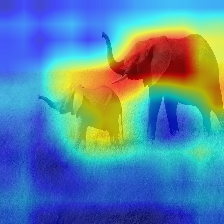

In [ ]:
array_to_img(cam)

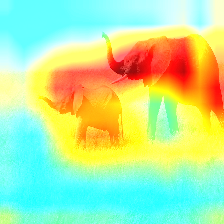

In [ ]:
# cam.max()
cv2_imshow(cv2.cvtColor(cam, cv2.COLOR_RGB2BGR))
# array_to_img(x)

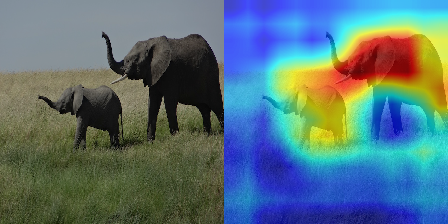

In [ ]:
im_h = cv2.hconcat([x, cam])
array_to_img(im_h)
# cv2.imwrite("/content/concat.png", im_h)
# cat = img_to_array(load_img("/content/concat.png", target_size=IMAGE_SIZE))
# array_to_img(cat)

In [ ]:
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

In [ ]:
img = img_to_array(load_img("/content/gradcam.png", target_size=(2000,500)))
cv2_imshow(img)